In [1]:
%env DGLBACKEND=pytorch

import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import r3_diffuser
from data import so3_diffuser
from model import loss
from model import reverse_se3_diffusion, reverse_diffusion_SE3_tfmr

import tree
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation

from omegaconf import OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format="%(asctime)s %(message)s", datefmt=date_strftime_format)

env: DGLBACKEND=pytorch


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dswb47jw because the default path (/afs/csail.mit.edu/u/b/btrippe/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
INFO: Using numpy backend


In [2]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(reverse_se3_diffusion)
importlib.reload(reverse_diffusion_SE3_tfmr)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/btrippe/protein_diffusion_v2/experiments/train_se3_diffusion.py'>

In [3]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False
exp_conf.normalize_pred_score = True
exp_conf.batch_size = 12

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0
data_conf.digs.crop_len = None
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0
data_conf.digs.crop_len = None

data_conf.rosetta.filtering.subset = 1
data_conf.rosetta.filtering.max_len = 128

diff_conf = conf.diffuser
diff_conf.diffuse_trans = True
diff_conf.diffuse_rot = True

diff_conf.rot_schedule = 'linear'
diff_conf.trans_schedule = 'exponential'

diff_conf.trans_align_t = True


# model config settings
model_conf = conf.model
model_conf['network_type'] = 'se3_tfmr'


# print(OmegaConf.to_yaml(conf))

In [4]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 665170
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Evaluation saved to: ./results/baseline/13D_09M_2022Y_20h_13m_27s
INFO: Training: 1 examples
INFO: Validation: 4 examples with lengths [125 125 125 125 125 125 125 125 125 125]


In [5]:
exp_conf

{'name': 'baseline', 'data_location': 'rosetta', 'wandb_dir': './', 'run_id': None, 'log_freq': 1000, 'batch_size': 12, 'num_loader_workers': 1, 'num_epoch': 10000, 'learning_rate': 0.0001, 'ckpt_dir': None, 'ckpt_freq': 10000, 'warm_start': None, 'use_warm_start_conf': True, 'port': 12319, 'dist_mode': 'single', 'use_wandb': False, 'prefetch_factor': 100, 'trans_loss_weight': 1.0, 'rot_loss_weight': 1.0, 'psi_loss_weight': 1.0, 'psi_loss_t_filter': 0.2, 't_schedule': 'linear', 'eval_dir': './results/baseline/13D_09M_2022Y_20h_13m_27s', 'normalize_pred_score': True}

## Training

In [6]:
step = 0
epoch = 0
train_losses = defaultdict(list)
log_losses = defaultdict(list)
latest_aux_data = []
sampled_ts = []

In [ ]:
num_epochs = 100000
def update_logs(x,y):
    for k in y:
        if 'loss' in k:
            x[k].append(y[k])
log_freq = 25

exp._model = exp._model.to(device)
exp._model.train()
while epoch < num_epochs:
    epoch += 1
    for train_features in train_loader:
        step += 1
        exp.step = step
        exp.num_epochs = epoch
        sampled_ts.append(train_features['t'])
        train_features = tree.map_structure(
            lambda x: x.to(device), train_features)
        _, aux_data = exp.update_fn(train_features)
        aux_data = tree.map_structure(du.move_to_np, aux_data)
        latest_aux_data.append(aux_data)
        update_logs(train_losses, aux_data)
        update_logs(log_losses, aux_data)
        if step == 1 or step % log_freq == 0:
            print_log = f'Step {step}: '
            for k,v in log_losses.items():
                print_log += f'{k}={np.mean(v):.4f} '
            print(print_log)
            log_losses = defaultdict(list)
            latest_aux_data = []

node_embed, node_out_l1 var:  0.23878132 0.012809229
Step 1: total_loss=2.6457 rot_loss=1.1495 trans_loss=1.2462 psi_loss=0.2500 
node_embed, node_out_l1 var:  0.23433946 0.012048585
node_embed, node_out_l1 var:  0.22975087 0.013779681
node_embed, node_out_l1 var:  0.24037735 0.015925674
node_embed, node_out_l1 var:  0.24013847 0.01934509
node_embed, node_out_l1 var:  0.22396474 0.0235577
node_embed, node_out_l1 var:  0.23608625 0.0273178
node_embed, node_out_l1 var:  0.22957358 0.030909529
node_embed, node_out_l1 var:  0.23202503 0.0326956
node_embed, node_out_l1 var:  0.22661707 0.036183234
node_embed, node_out_l1 var:  0.22825003 0.040358204
node_embed, node_out_l1 var:  0.22850162 0.041471478
node_embed, node_out_l1 var:  0.22970237 0.042684346
node_embed, node_out_l1 var:  0.23975277 0.046222575
node_embed, node_out_l1 var:  0.23479338 0.042599764
node_embed, node_out_l1 var:  0.23096704 0.040575426
node_embed, node_out_l1 var:  0.23309305 0.039200153
node_embed, node_out_l1 var: 

node_embed, node_out_l1 var:  0.22801907 0.13314632
node_embed, node_out_l1 var:  0.23559754 0.12071217
Step 150: total_loss=1.7019 rot_loss=1.1483 trans_loss=0.4598 psi_loss=0.0938 
node_embed, node_out_l1 var:  0.22696424 0.13991633
node_embed, node_out_l1 var:  0.22347808 0.14654869
node_embed, node_out_l1 var:  0.23052245 0.11792584
node_embed, node_out_l1 var:  0.24264966 0.11183475
node_embed, node_out_l1 var:  0.23829429 0.13302359
node_embed, node_out_l1 var:  0.23803705 0.109126285
node_embed, node_out_l1 var:  0.24211498 0.11564154
node_embed, node_out_l1 var:  0.23289847 0.12746164
node_embed, node_out_l1 var:  0.24114199 0.11680725
node_embed, node_out_l1 var:  0.24165873 0.12595727
node_embed, node_out_l1 var:  0.23351423 0.11915366
node_embed, node_out_l1 var:  0.23505335 0.124854125
node_embed, node_out_l1 var:  0.23638262 0.11939506
node_embed, node_out_l1 var:  0.23814598 0.13985361
node_embed, node_out_l1 var:  0.24591392 0.11490187
node_embed, node_out_l1 var:  0.236

In [ ]:
f, axes = plt.subplots(1, 4, figsize=[24, 5])

axes[0].plot(train_losses['rot_loss'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('Rotation loss')

axes[1].plot(train_losses['trans_loss'])
axes[1].set_xlabel('steps')
axes[1].set_ylabel('Translation loss')

axes[2].plot(train_losses['psi_loss'])
axes[2].set_xlabel('steps')
axes[2].set_ylabel('Psi loss')

axes[3].plot(train_losses['total_loss'])
axes[3].set_xlabel('steps')
axes[3].set_ylabel('Total loss')

In [14]:
ckpt_path = './dev_models/test.pkl'
du.write_checkpoint(
    ckpt_path, exp.model.state_dict(), exp._conf)

Serializing experiment state to ./dev_models/test.pkl


## Data visualization

In [15]:
# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

ConfigKeyError: Missing key network_type
    full_key: model.network_type
    object_type=dict

In [16]:
train_iter = iter(train_loader)
next_item = next(train_iter)
print(next_item['t'])

RuntimeError: DataLoader worker (pid(s) 59344) exited unexpectedly

In [ ]:
torch.sum(next_item['res_mask'][0])

In [17]:
# Visualize example
b_idx = -4
rigids_t, noisy_se3_vec = process_rigids(next_item['rigids_t'], b_idx)
rigids_0, gt_se3_vec = process_rigids(next_item['rigids_0'], b_idx)

ax_lim = 15
f, axes = plt.subplots(1, 2, figsize=[16, 8], subplot_kw=dict(projection="3d"))
plotting.plot_se3(gt_se3_vec, ax=axes[0], title='Initialization', ax_lim=ax_lim)
plotting.plot_se3(noisy_se3_vec, ax=axes[1], title='Sampled frame', ax_lim=ax_lim)

NameError: name 'process_rigids' is not defined

## Sampling

In [14]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [15]:
# Preprocess init data
exp_diffuser = exp.diffuser
batch_idx = 2
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

rigids_0 = rigids_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]


In [16]:

num_res = res_mask.shape[0]
rigids_init = exp_diffuser.sample_ref(
    num_res,
#     impute=ru.Rigid.from_tensor_7(rigids_0)
).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init,
    'res_mask': res_mask,
    'res_idx': res_idx,
#     'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(1.0),
    'rot_score_norm': data_feats['rot_score_norm'],
    'trans_score_norm': data_feats['trans_score_norm'],
}

num_res = res_mask.shape[0]
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)
print(f'Sample length {torch.sum(res_mask)}')

Sample length 152.0


In [17]:
# Run inference
infer_out = exp.inference_fn(init_feats, add_noise=True)
sample_rigids = infer_out[0]

KeyError: 'aatype'

In [18]:
# Plot out SE(3)
final_rigid = sample_rigids[-1][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

NameError: name 'sample_rigids' is not defined

In [190]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
    final_rigid,
    rigids_0.to(device),
    res_mask.to(device),
    length_scale=scale_factor,
    return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


FAPE: 0.0319
Ca-RMSD: 1.4931
Alignment rotation: [-158.46177987   66.47578861  -47.74467577]
Alignment translation: [ 6.641922e-08 -5.957877e-08  3.364813e-08]
Alignment reflection: False


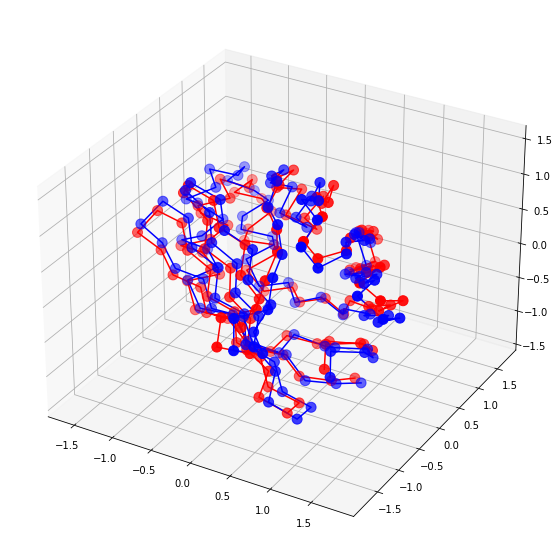

In [191]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')